In [68]:
import os, time, datetime, sys
import numpy as np
import pandas as pd
from collections import Counter
from functools import reduce
from dateutil.relativedelta import relativedelta
from sklearn.metrics import roc_curve, auc, f1_score, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib
import random
from IPython.display import display
import seaborn as sns

# 1.1 读取数据并预览

In [69]:
# Read data
userinfo_train = pd.read_csv('./userinfo.csv')
bank_train = pd.read_csv('./bank.csv')
bill_train = pd.read_csv('./bill.csv')
overdue_train = pd.read_csv('./overdue.csv')

df_dict = {"用户信息": userinfo_train,
"银行流水": bank_train,
"账单": bill_train,
"违约记录": overdue_train}

In [70]:
# Show info
for name in df_dict:
    print(name+":", len(df_dict[name]), "行")
    display(df_dict[name].head())

用户信息: 10000 行


,new_user_id,性别,职业,教育程度,婚姻状态,户口类型
0,7259fe272934e0dc348092c37544a445,女,公职,本科及以上,未婚,集体户口
1,0c87f6b1f7e0350a35841ba34df9d26a,男,公职,本科及以上,离异,集体户口
2,74c53a62f15cc039864aefc41170f81b,男,公职,大专,离异,家庭户口
3,211f56f356fa6ecc6334bb73e52c7b16,男,企业,高中,离异,农业户口
4,07b0d9ac7924424894141b2fecfa0ee0,男,公职,本科及以上,已婚,集体户口


银行流水: 1068424 行


,new_user_id,交易时间戳,交易类型,交易金额,工资收入标记,交易时间,交易年,交易月,交易日,交易时,交易分,交易秒
0,65b01fba105ee82613babff7c88929c5,58848407247,1,43.757548,0,2156-06-25 21:58:44,2156,6,25,21,58,44
1,65b01fba105ee82613babff7c88929c5,58849365297,1,42.143743,0,2156-06-27 00:35:29,2156,6,27,0,35,29
2,65b01fba105ee82613babff7c88929c5,58850118237,1,40.189051,0,2156-06-27 21:30:23,2156,6,27,21,30,23
3,65b01fba105ee82613babff7c88929c5,58850118447,1,40.189051,0,2156-06-27 21:30:44,2156,6,27,21,30,44
4,65b01fba105ee82613babff7c88929c5,58850244487,1,40.189051,0,2156-06-28 01:00:48,2156,6,28,1,0,48


账单: 429441 行


,new_user_id,账单时间戳,银行id,上期账单金额,上期还款金额,信用卡额度,本期账单余额,本期账单最低还款额,消费笔数,本期账单金额,...,可用金额,预借现金额度,还款状态,账单时间,账单年,账单月,账单日,账单时,账单分,账单秒
0,eddcaa8984f8db5199ec28323efb18a4,59067443637,6,50.622246,50.657612,52.596975,50.897707,49.846899,1,26.457513,...,26.457513,51.933872,0,2157-03-06 10:19:23,2157,3,6,10,19,23
1,eddcaa8984f8db5199ec28323efb18a4,59067444017,6,50.897707,50.901821,52.596975,51.101179,49.911428,1,26.457513,...,26.457513,51.933872,0,2157-03-06 10:20:01,2157,3,6,10,20,1
2,eddcaa8984f8db5199ec28323efb18a4,59067444277,6,51.101179,51.137354,52.596975,51.283715,49.977605,1,26.457513,...,26.457513,51.933872,0,2157-03-06 10:20:27,2157,3,6,10,20,27
3,eddcaa8984f8db5199ec28323efb18a4,59067445157,6,51.283715,51.283799,52.915867,52.252502,50.474921,1,26.457513,...,26.457513,52.256811,0,2157-03-06 10:21:55,2157,3,6,10,21,55
4,eddcaa8984f8db5199ec28323efb18a4,59067445627,6,52.252502,52.256812,52.915867,52.304048,50.508400,1,26.457513,...,26.457513,52.256811,0,2157-03-06 10:22:42,2157,3,6,10,22,42


违约记录: 10000 行


,new_user_id,标签,分数
0,eddcaa8984f8db5199ec28323efb18a4,0,80.619639
1,65b01fba105ee82613babff7c88929c5,1,53.052357
2,968083a2d1a7e6b5b85a66b0bc412830,1,46.796518
3,18aeed58fd39a58cc1430a3a417ed7a9,1,82.354501
4,bae4896cea4a34616ae3babca11439ae,1,83.758928


# 1.2 列出空值并删除

In [71]:
# show whether a table contains null value
for name in df_dict:
    print("%s:%s" %(name, np.any(df_dict[name].isnull())))

用户信息:True
银行流水:False
账单:False
违约记录:False


In [72]:
# Show specific info of null value table 
for name in df_dict:
    df = df_dict[name]
    if np.any(df.isnull()):
        print("%s存在空值" %name)
        print(df.isnull().sum(axis=0))
        display(df[df.isnull().any(axis=1)])
        print("存在 %d 行空值" %len(df[df.isnull().any(axis=1)]))

        # Drop null record
        df_dict[name] = df[~df.isnull().any(axis=1)]
        print("%s已更新" %name)

用户信息存在空值
new_user_id    0
性别             0
职业             2
教育程度           0
婚姻状态           1
户口类型           0
dtype: int64


,new_user_id,性别,职业,教育程度,婚姻状态,户口类型
31,3be79a55ccf09062cdff1b9c684179f9,男,NaN,本科及以上,离异,农业户口
135,b074add6f740af33df4230f28d37a333,男,NaN,大专,离异,家庭户口
5345,9f2e0eb314d821f8d075fbc9e64ce4f5,男,公职,高中,NaN,农业户口


存在 3 行空值
用户信息已更新


In [73]:
# 加一个要用的标签
def SexMrg(series):
    sex = series['性别']
    marriage = series['婚姻状态']

    if marriage == '未知':
        return '其他'
    
    if sex == '男':
        if marriage == '已婚':
            return '男已婚'
        else:
            return '男单身'
    elif sex == '女':
        if marriage == '已婚':
            return '女已婚'
        else:
            return '女单身'
    else:
        return '其他'

x = df_dict['用户信息'].copy()
x.loc[:, '性别婚姻']= x[['性别','婚姻状态']].apply(SexMrg, axis=1)
df_dict['用户信息'] = x

In [74]:
x = df_dict['银行流水'].copy()
x.loc[:, '交易年月']= df_dict['银行流水']['交易时间'].str[:7]
df_dict['银行流水'] = x

x = df_dict['账单'].copy()
x.loc[:, '账单年月']= df_dict['账单']['账单时间'].str[:7]
df_dict['账单'] = x

# 1.3 描述性统计和部分数据的探索性可视化

In [75]:
# 描述性统计
def describe(dataframe, features):
    output = pd.DataFrame(columns=('Variable', 'Count', 'Mean', 'Minimum', 'Median', 'Max', 'Std.Error'))

    for feature in features:
        rec = pd.Series({
            'Variable':feature,
            'Count':int(dataframe[[feature]].count()),
            'Mean':dataframe[feature].mean(),
            'Minimum':dataframe[feature].min(),
            'Median':dataframe[feature].median(),
            'Max':dataframe[feature].max(),
            'Std.Error':dataframe[feature].std()
        })
        output = output.append(rec, ignore_index=True)

    display(output)
    
df1=df_dict["银行流水"][['交易类型','工资收入标记', '交易年', '交易月', '交易金额']]
df2=df_dict["账单"][[
    '银行id',
    '消费笔数',
    '还款状态',
    '账单年',
    '账单月',

    '上期账单金额',
    '上期还款金额',
    '信用卡额度',
    '本期账单余额',
    '本期账单最低还款额',
    '本期账单金额',
    '调整金额',
    '循环利息',
    '可用金额',
    '预借现金额度',
    ]]

describe(df1, df1.columns)
describe(df2, df2.columns)

,Variable,Count,Mean,Minimum,Median,Max,Std.Error
0,交易类型,1068424,0.718620,0,1.000000,1,0.449673
1,工资收入标记,1068424,0.006262,0,0.000000,1,0.078882
2,交易年,1068424,2143.780544,-1,2157.000000,2157,167.280581
3,交易月,1068424,6.488838,-1,7.000000,12,3.173373
4,交易金额,1068424,43.415927,30.568844,43.757548,54.742125,3.052264


,Variable,Count,Mean,Minimum,Median,Max,Std.Error
0,银行id,429441,65.655119,1,7.000000,510057,5391.682647
1,消费笔数,429441,0.938557,0,0.000000,66,2.107799
2,还款状态,429441,0.000177,0,0.000000,1,0.013302
3,账单年,429441,1775.973566,-1,2157.000000,2158,822.568833
4,账单月,429441,5.724065,-1,6.000000,12,4.495355
5,上期账单金额,429441,43.671535,-40.764184,51.533573,56.099275,15.723186
6,上期还款金额,429441,43.851250,-41.068863,50.408951,59.240038,11.974119
7,信用卡额度,429441,47.433108,-39.288318,52.109109,56.609579,10.275608
8,本期账单余额,429441,49.752169,-40.764184,52.057547,57.044997,12.137559
9,本期账单最低还款额,429441,48.434824,-38.673616,50.130989,55.552242,8.780099


# 分析
交易年，交易月都有-1
账单年，账单月都有-1

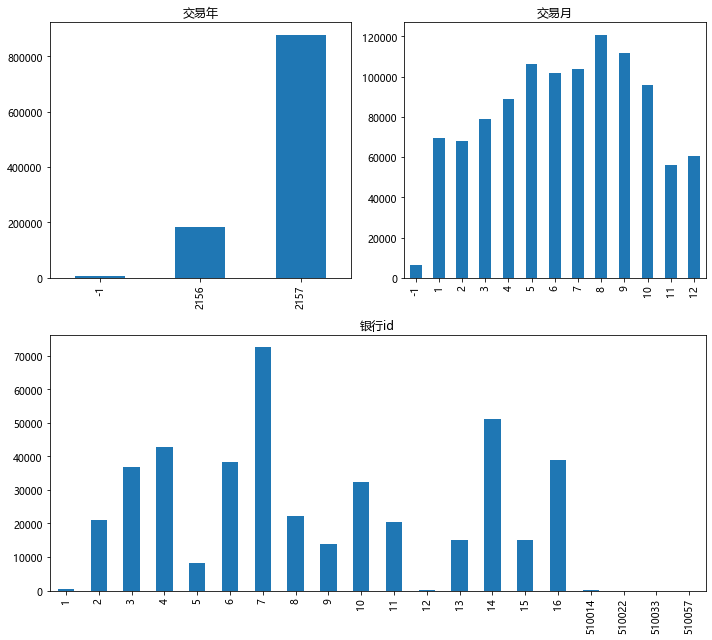

In [79]:
fig1 = plt.figure(figsize=(10, 9), facecolor='w')
plt.rcParams['font.family'] = ['Arial Unicode MS', 'Microsoft Yahei', 'SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

ax1 = fig1.add_subplot(2,2,1)
bank_train['交易年'].value_counts().sort_index().plot.bar(plt.title('交易年'))
ax2 = fig1.add_subplot(2,2,2)
bank_train['交易月'].value_counts().sort_index().plot.bar(plt.title('交易月'))
ax3 = fig1.add_subplot(2,1,2)
bill_train['银行id'].value_counts().sort_index().plot.bar(plt.title('银行id'))

fig1.tight_layout()

# 查看时间异常值
发现时间异常的记录所有属性均为-1

In [80]:
error_index = bank_train["交易年"] | bank_train["交易月"] < 0
print("年月份异常：%d行" %bank_train[error_index].shape[0])
bank_train[error_index].head()

年月份异常：6460行


,new_user_id,交易时间戳,交易类型,交易金额,工资收入标记,交易时间,交易年,交易月,交易日,交易时,交易分,交易秒
1068,03f0b9d856c455ac62ca4093a34e6715,7,0,52.078401,0,-1,-1,-1,-1,-1,-1,-1
1069,03f0b9d856c455ac62ca4093a34e6715,7,0,48.675622,0,-1,-1,-1,-1,-1,-1,-1
1070,03f0b9d856c455ac62ca4093a34e6715,7,0,51.352242,0,-1,-1,-1,-1,-1,-1,-1
1071,03f0b9d856c455ac62ca4093a34e6715,7,0,52.241861,0,-1,-1,-1,-1,-1,-1,-1
1072,03f0b9d856c455ac62ca4093a34e6715,7,0,51.844007,0,-1,-1,-1,-1,-1,-1,-1


In [81]:
error_index = df_dict['账单']["账单年"] | df_dict['账单']["账单月"] < 0
print("年月份异常：%d行" %df_dict['账单'][error_index].shape[0])
df_dict['账单'][error_index].head()

年月份异常：75782行


,new_user_id,账单时间戳,银行id,上期账单金额,上期还款金额,信用卡额度,本期账单余额,本期账单最低还款额,消费笔数,本期账单金额,...,预借现金额度,还款状态,账单时间,账单年,账单月,账单日,账单时,账单分,账单秒,账单年月
38,65b01fba105ee82613babff7c88929c5,7,10,52.124921,53.327500,52.109109,52.010327,49.045912,0,53.297339,...,26.457513,0,-1,-1,-1,-1,-1,-1,-1,-1
39,65b01fba105ee82613babff7c88929c5,7,7,51.575085,52.904322,51.718591,51.664640,50.364744,1,52.926876,...,26.457513,0,-1,-1,-1,-1,-1,-1,-1,-1
40,65b01fba105ee82613babff7c88929c5,7,10,51.076890,52.671403,52.109109,51.728028,50.409782,0,52.830097,...,26.457513,0,-1,-1,-1,-1,-1,-1,-1,-1
41,65b01fba105ee82613babff7c88929c5,7,10,52.010327,53.659329,52.109109,51.076890,50.406425,0,53.552523,...,51.439717,0,-1,-1,-1,-1,-1,-1,-1,-1
42,65b01fba105ee82613babff7c88929c5,7,10,51.076890,52.671403,52.109109,51.728028,50.409782,0,52.830097,...,51.439717,0,-1,-1,-1,-1,-1,-1,-1,-1


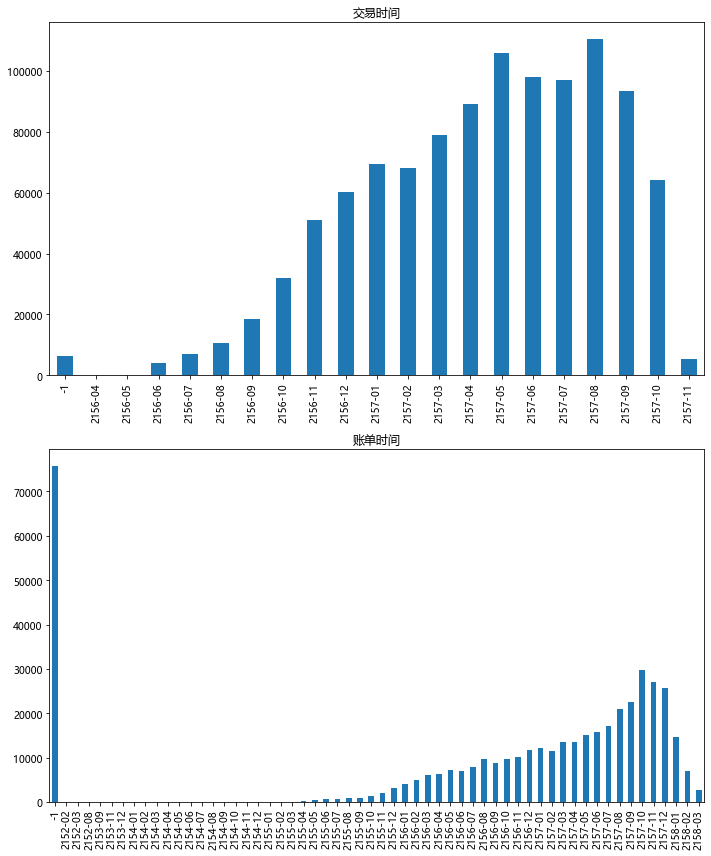

In [83]:
fig2 = plt.figure(figsize=(10, 12), facecolor='w')
plt.rcParams['font.family'] = ['Arial Unicode MS', 'Microsoft Yahei', 'SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

ax1 = fig2.add_subplot(2,1,1)
df_dict['银行流水']['交易年月'].value_counts().sort_index().plot.bar(plt.title('交易时间'))

ax2 = fig2.add_subplot(2,1,2)
df_dict['账单']['账单年月'].value_counts().sort_index().plot.bar(plt.title('账单时间'))

fig2.tight_layout()

# 可选项：截取一年时间范围2156.11-2157.10

In [21]:
# error_index = bank_train["交易年"] | bank_train["交易月"] < 0
# print("年月份异常：%d行" %bank_train[error_index].shape[0])
# bank_train[error_index].head()

cut_bank_range = False

if cut_bank_range:
    df_dict['银行流水'] = bank_train[((bank_train['交易年']<=2156) & (bank_train['交易月']<=10)) | ((bank_train['交易年'] >= 2157) & (bank_train['交易月']>=11))]

(83844, 12)

# 1.4 编码
分类编码和独热编码

In [85]:
# Generate dictionary of code for a certain table.
def genCode(pdtable, colList):
    # For safety, you must commit a list sured by yourself.

    code_dict = {}

    for col in colList:
        # Show unique value of a column
        colValue = list(pdtable[col].unique())
        print(col, colValue)

        # Enode of column
        dict = {}
        for index in range(len(colValue)):
            dict[colValue[index]] = index

        # Show result
        print("编码：%s\n" %dict)
        
        # Store data
        code_dict[col] = dict
    return code_dict

col_list=list(df_dict['用户信息'])
col_list.remove('new_user_id')
code_dict = genCode(df_dict['用户信息'], col_list)

df_dict['用户信息'] = df_dict['用户信息'].replace(code_dict)

性别 ['女', '男', '未知']
编码：{'女': 0, '男': 1, '未知': 2}

职业 ['公职', '企业', '事业单位', '无业', '学生']
编码：{'公职': 0, '企业': 1, '事业单位': 2, '无业': 3, '学生': 4}

教育程度 ['本科及以上', '大专', '高中', '初中及以下', '未知']
编码：{'本科及以上': 0, '大专': 1, '高中': 2, '初中及以下': 3, '未知': 4}

婚姻状态 ['未婚', '离异', '已婚', '丧偶', '其他情况', '未知']
编码：{'未婚': 0, '离异': 1, '已婚': 2, '丧偶': 3, '其他情况': 4, '未知': 5}

户口类型 ['集体户口', '家庭户口', '农业户口', '其他户口', '未知']
编码：{'集体户口': 0, '家庭户口': 1, '农业户口': 2, '其他户口': 3, '未知': 4}

性别婚姻 ['女单身', '男单身', '男已婚', '其他', '女已婚']
编码：{'女单身': 0, '男单身': 1, '男已婚': 2, '其他': 3, '女已婚': 4}



In [84]:
# One-Hot Encoding
one_hot = False
if one_hot:
    col_list=list(df_dict['用户信息'])
    col_list.remove('new_user_id')
    df_dict['用户信息OH'] = pd.get_dummies(df_dict['用户信息'], columns=col_list)
    df_dict['用户信息OH'].head(5)

# 1.5 部分标签的相关热力图

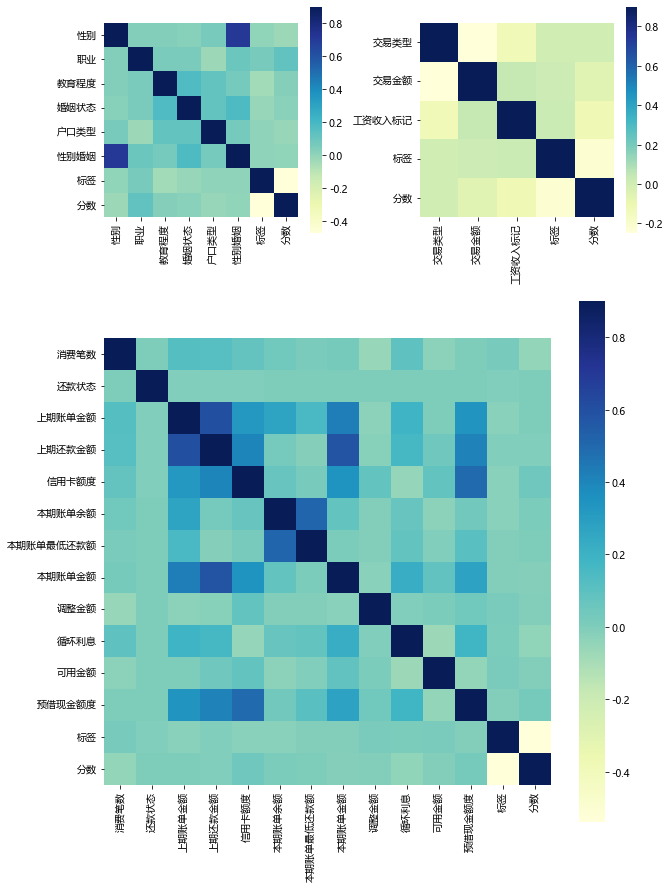

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

In [88]:
def corrHeat(Data, ax):
    plt.rcParams['font.family'] = ['Arial Unicode MS', 'Microsoft Yahei', 'SimHei'] #用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
    # sns.set_style('whitegrid',{'font.sans-serif':['Arial Unicode MS','Arial']})

    corr = Data.corr()
    plt.figure(figsize=(15,12))
    g = sns.heatmap(corr, vmax=0.9, cmap="YlGnBu", square=True, ax = ax)
    # plt.show()
    return g

fig3 = plt.figure(figsize=(10, 15), facecolor='w')
grid = plt.GridSpec(3, 2, wspace=0.3, hspace=0.3)

userinfo_merge = pd.merge(df_dict['用户信息'], df_dict['违约记录'], on='new_user_id')
ax1 = fig3.add_subplot(grid[0,0])
corrHeat(userinfo_merge.drop(['new_user_id'], axis=1), ax1)

userinfo_merge = pd.merge(df_dict['银行流水'][['new_user_id','交易类型','交易金额','工资收入标记']], df_dict['违约记录'], on='new_user_id')
ax2 = fig3.add_subplot(grid[0, 1])
corrHeat(userinfo_merge.drop(['new_user_id'], axis=1), ax2)

userinfo_merge = pd.merge(df_dict['账单'][[
    'new_user_id',
    '消费笔数',
    '还款状态',

    '上期账单金额',
    '上期还款金额',
    '信用卡额度',
    '本期账单余额',
    '本期账单最低还款额',
    '本期账单金额',
    '调整金额',
    '循环利息',
    '可用金额',
    '预借现金额度',]]
    , df_dict['违约记录'], on='new_user_id')
ax3 = fig3.add_subplot(grid[1:, 0:])
corrHeat(userinfo_merge.drop(['new_user_id'], axis=1), ax3)

plt.tight_layout()

# 2.1 单变量
职业、教育程度、婚姻状态、户口类型、性别婚姻  

不选择标准化或选择一种标准化（min-max或Z-score）

In [89]:
# min-max标准化
def mNormalization(dataframe, column):
    single = pd.DataFrame(dataframe[column],columns=[column])
    single = single.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    dataframe[column] = single[column]
    return dataframe

# Z-score标准化
def zNormalization(dataframe, column):
    single = pd.DataFrame(dataframe[column],columns=[column])
    single = single.apply(lambda x: (x - np.mean(x)) / np.std(x))
    dataframe[column] = single[column]
    return dataframe

norm_mode = 'continue' # continue, minmax, zscore

if norm_mode == 'continue':
    df = pd.merge(df_dict['用户信息'], df_dict['违约记录'], on='new_user_id', how='left')
elif:
    df = pd.merge(df_dict['用户信息'], df_dict['违约记录'], on='new_user_id', how='left')
    df = mNormalization(df, '分数')
    # df['分数'].plot.hist()
elif:
    df = pd.merge(df_dict['用户信息'], df_dict['违约记录'], on='new_user_id', how='left')
    df = zNormalization(df, '分数')
    # df['分数'].plot.hist()

df.head()

,new_user_id,性别,职业,教育程度,婚姻状态,户口类型,性别婚姻,标签,分数
0,7259fe272934e0dc348092c37544a445,0,0,0,0,0,0,0,70.260853
1,0c87f6b1f7e0350a35841ba34df9d26a,1,0,0,1,0,1,1,22.963381
2,74c53a62f15cc039864aefc41170f81b,1,0,1,1,1,1,1,33.866533
3,211f56f356fa6ecc6334bb73e52c7b16,1,1,2,1,2,1,0,80.170224
4,07b0d9ac7924424894141b2fecfa0ee0,1,0,0,2,0,2,0,73.980588


回归任务：分数
变量：['职业']
均方差：0.9390



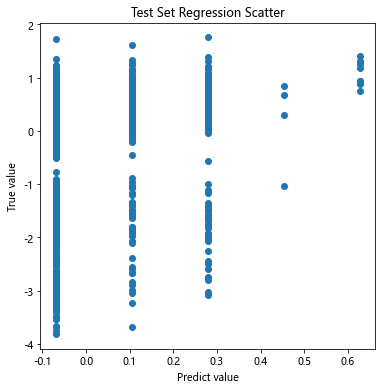

回归任务：分数
变量：['教育程度']
均方差：0.9529



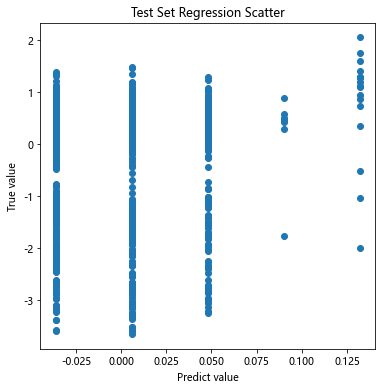

回归任务：分数
变量：['婚姻状态']
均方差：1.0184



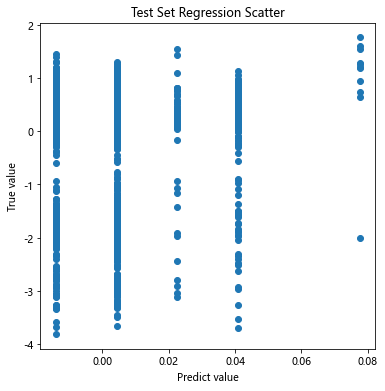

回归任务：分数
变量：['户口类型']
均方差：0.9868



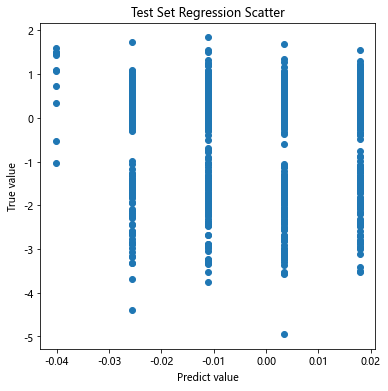

回归任务：分数
变量：['性别婚姻']
均方差：1.0521



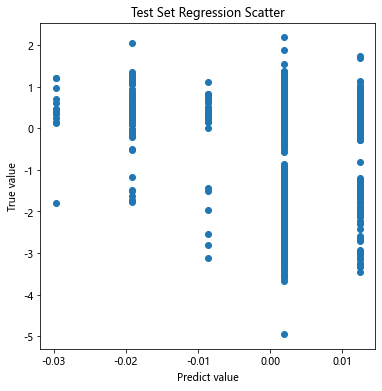

In [119]:
def VarRegression(dataframe: pd.DataFrame, depVar: str, indVarList: list, testsize: float=0.2, kline: bool=True):
    X_train, X_test, Y_train, Y_test = train_test_split(dataframe[indVarList], dataframe[[depVar]], test_size=testsize)
    model = LinearRegression()
    model.fit(X_train, Y_train)
    # print(model.intercept_, model.coef_)
    Y_predict_value = model.predict(X_test)
    
    mse = mean_squared_error(Y_test, Y_predict_value)
    print("回归任务：%s\n变量：%s\n均方差：%.4f\n" %(depVar, indVarList, mse))

    plt.figure(figsize=(6, 6), facecolor='w')
    plt.rcParams['font.family'] = ['Arial Unicode MS', 'Microsoft Yahei', 'SimHei'] #用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
    
    plt.title('Test Set Regression Scatter')
    plt.scatter(Y_predict_value, Y_test)
    plt.xlabel('Predict value')
    plt.ylabel('True value')
    if kline:
        minimum = np.min([Y_predict_value, Y_test])
        maximum = np.max([Y_predict_value, Y_test])
        plt.plot([minimum, maximum], [minimum, maximum], 'k--')
    plt.show()

features = ['职业','教育程度','婚姻状态','户口类型','性别婚姻']
# df = mNormalization(df, '职业')

for feature in features:
    VarRegression(df, '分数', [feature], kline=False)

分类任务：标签
变量：['职业']



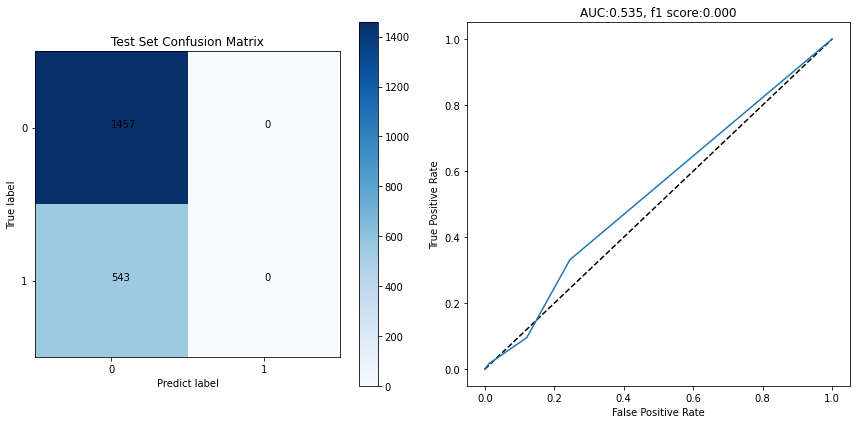

分类任务：标签
变量：['教育程度']



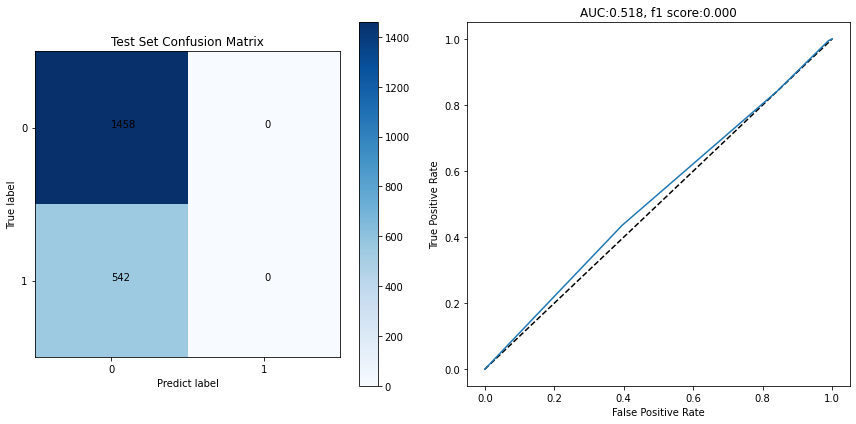

分类任务：标签
变量：['婚姻状态']



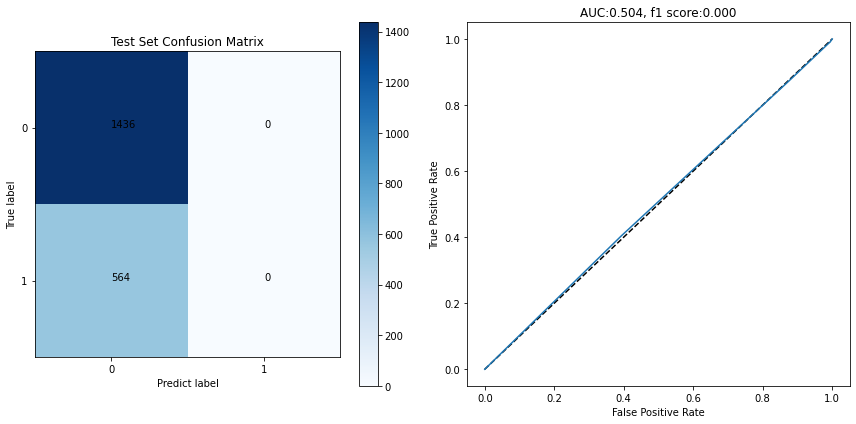

分类任务：标签
变量：['户口类型']



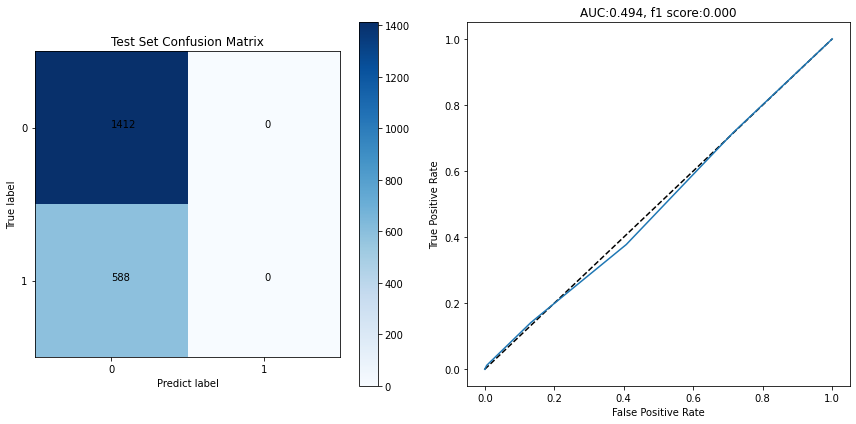

分类任务：标签
变量：['性别婚姻']



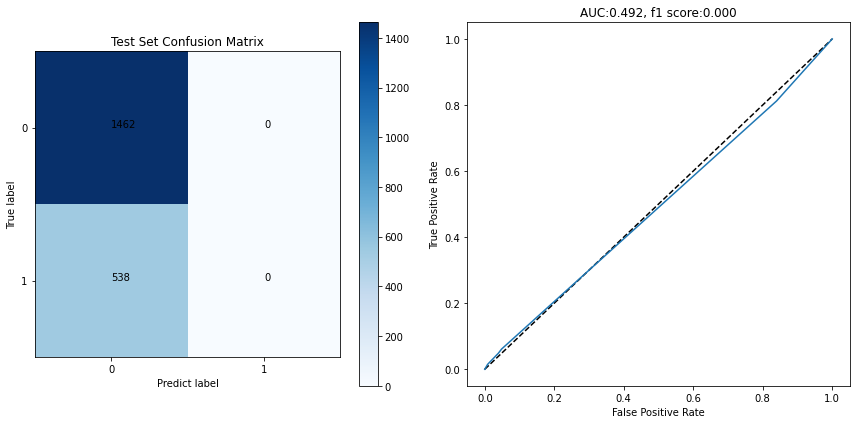

In [93]:
def VarClassification(dataframe: pd.DataFrame, depVar: str, indVarList: list, testsize: float=0.2):
    X_train, X_test, Y_train, Y_test = train_test_split(df[indVarList], df[[depVar]], test_size=testsize)
    model = LogisticRegression()
    model.fit(X_train, Y_train.values.ravel())
    Y_predict_value = model.predict_proba(X_test)[:, 1]  # 各个测试样本 softmax ，用于计算 roc
    Y_predict_label = model.predict(X_test)  # 各个测试样本预测出的标签

    print("分类任务：%s\n变量：%s\n" %(depVar, indVarList))

    fig4 = plt.figure(figsize=(12, 6), facecolor='w')
    plt.rcParams['font.family'] = ['Arial Unicode MS', 'Microsoft Yahei', 'SimHei'] #用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

    # Plot confusion matrix
    confusion = confusion_matrix(Y_test, Y_predict_label)
    # print(confusion)
    ax1 = fig4.add_subplot(1,2,1)
    # Generate ticks
    classes = list(set(df[depVar]))
    classes.sort()

    plt.title('Test Set Confusion Matrix')
    plt.imshow(confusion, cmap=plt.cm.Blues)
    plt.colorbar()
    plt.xticks(range(len(confusion)), classes)
    plt.yticks(range(len(confusion)), classes)
    plt.xlabel('Predict label')
    plt.ylabel('True label')
    for y_index in range(len(confusion)):
        for x_index in range(len(confusion[y_index])):
            plt.text(x_index, y_index, confusion[y_index][x_index])

    # Plot ROC curve
    ax2 = fig4.add_subplot(1,2,2)
    fpr, tpr, thresholds = roc_curve(Y_test, Y_predict_value)
    roc_auc = auc(fpr, tpr)
    plt.title('AUC:%.3f, f1 score:%.3f' %(roc_auc, f1_score(Y_test, Y_predict_label)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)

    fig4.tight_layout()
    plt.show()

features = ['职业','教育程度','婚姻状态','户口类型','性别婚姻']
for feature in features:
    VarClassification(df, '标签', [feature])

# 特征工程 1
职业、教育程度、信用卡数量、工资收入平均值、欠款额平均值。

In [94]:
# 信用卡数量	统计非重复银行id数量
cards_count = df_dict['账单'].groupby("new_user_id")['银行id'].agg([pd.Series.nunique])
cards_count.columns = ['信用卡数量']
cards_count.reset_index(inplace=True)
cards_count.head()

,new_user_id,信用卡数量
0,0000a11bede26d01990cd7bf86a4ffed,3
1,0001102f53f24a8952ed5b47f9564354,2
2,000228d848615f1320914e0cf6064d12,1
3,0003f283dfacd7100bba76d876cf94da,1
4,000fc975cf7a868719446414a5034eae,5


In [95]:
# 工资收入平均值	银行流水“工资收入标记”为1的“交易金额”平均值
salary_mean = df_dict['银行流水'][df_dict['银行流水']['工资收入标记'] == 1].groupby("new_user_id")['交易金额'].agg(["mean"])
salary_mean.columns = ['工资收入平均值']
salary_mean.reset_index(inplace=True)
salary_mean.head(5)

,new_user_id,工资收入平均值
0,00375b8a7a62da4f578f4f4464fc4228,44.964550
1,00872649357929f1f3d7fafbe484810b,46.415984
2,00e44c200eeb161df7d08ac1b79bd4a7,47.292812
3,02419b54629f540d3430e6ba8230aac4,45.600048
4,024c12c231362aa4206c001674abe30f,40.380961


In [96]:
# 欠款金额平均值	账单“欠款金额”平均值
df_dict['账单']["欠款金额"] = df_dict['账单']["上期账单金额"] - df_dict['账单']["上期还款金额"]
debt_mean = df_dict['账单'].groupby("new_user_id")["欠款金额"].agg(["mean"])
debt_mean.columns = ['欠款金额平均值']
debt_mean.reset_index(inplace=True)
debt_mean.head(5)

,new_user_id,欠款金额平均值
0,0000a11bede26d01990cd7bf86a4ffed,1.595222
1,0001102f53f24a8952ed5b47f9564354,-1.647174
2,000228d848615f1320914e0cf6064d12,-24.352021
3,0003f283dfacd7100bba76d876cf94da,-3.289508
4,000fc975cf7a868719446414a5034eae,0.702195


In [97]:
df = pd.merge(df, cards_count, on='new_user_id', how='left')
df = pd.merge(df, salary_mean, on='new_user_id', how='left')
df = pd.merge(df, debt_mean, on='new_user_id', how='left')
df = df.fillna(0)

# 回归与分类

回归任务：分数
变量：['职业', '教育程度', '信用卡数量', '工资收入平均值', '欠款金额平均值']
均方差：0.4911



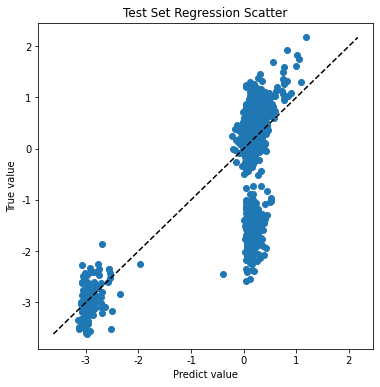

In [98]:
features_1 = ['职业','教育程度','信用卡数量','工资收入平均值','欠款金额平均值']
features = features_1
VarRegression(df, '分数', features_1)

分类任务：标签
变量：['职业', '教育程度', '信用卡数量', '工资收入平均值', '欠款金额平均值']



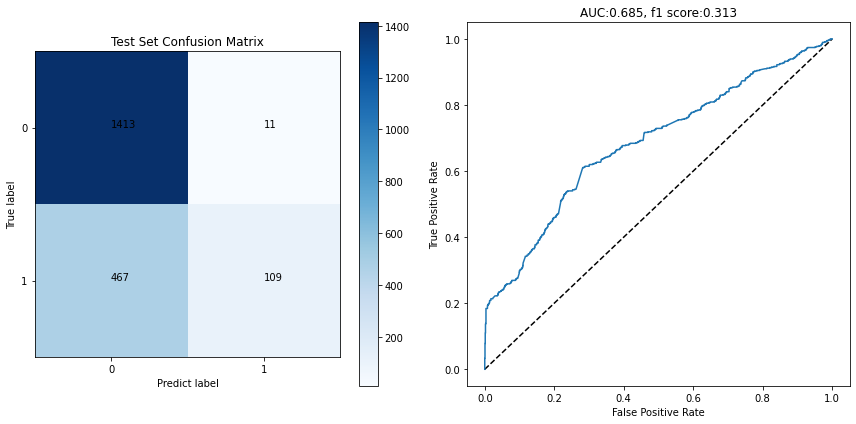

In [99]:
VarClassification(df, '标签', features_1)

# 特征工程 2
非工资收入平均值、非工资收入次数月均值、工资占收入比例月均值、支出次数月均值。

In [100]:
# 非工资收入平均值	银行流水“交易类型”为0且“工资收入标记”为0的“交易金额”平均值
nonsalary_mean = df_dict['银行流水'][
    (df_dict['银行流水']['交易类型'] == 0) & 
    (df_dict['银行流水']['工资收入标记'] == 0) & 
    (df_dict['银行流水']['交易年月'] != '-1')].groupby("new_user_id")['交易金额'].agg(["mean"])
nonsalary_mean.columns = ['非工资收入平均值']
nonsalary_mean.reset_index(inplace=True)
nonsalary_mean.head()

,new_user_id,非工资收入平均值
0,0003f283dfacd7100bba76d876cf94da,43.751671
1,00284cf15ae27d1ddf4f93922cd7bcb5,46.666179
2,00375b8a7a62da4f578f4f4464fc4228,44.779248
3,0057bbe021e9c3fc79834e3ff126bb98,45.167214
4,00872649357929f1f3d7fafbe484810b,42.547653


In [101]:
# 非工资收入次数月均值	银行流水“交易类型”为0且“工资收入标记”为0的数量除以出现的月数

# 去-1次数
nonsalary_count_monthly_mean = df_dict['银行流水'][
    (df_dict['银行流水']['交易类型'] == 0) & 
    (df_dict['银行流水']['工资收入标记'] == 0) & 
    (df_dict['银行流水']['交易年月'] != '-1')].groupby(['new_user_id','交易年月'])['交易金额'].count()

nonsalary_count_monthly_mean = nonsalary_count_monthly_mean.groupby('new_user_id').agg(["mean"])
nonsalary_count_monthly_mean.columns = ['非工资收入次数月均值']
nonsalary_count_monthly_mean.reset_index(inplace=True)
nonsalary_count_monthly_mean.head()

,new_user_id,非工资收入次数月均值
0,0003f283dfacd7100bba76d876cf94da,5.000000
1,00284cf15ae27d1ddf4f93922cd7bcb5,168.250000
2,00375b8a7a62da4f578f4f4464fc4228,18.700000
3,0057bbe021e9c3fc79834e3ff126bb98,7.769231
4,00872649357929f1f3d7fafbe484810b,1.857143


In [102]:
# 工资占收入比例月均值	银行流水“工资收入标记”为1的总量占当月总收入比例除以出现的月数

#  去-1月收入量
salary = df_dict['银行流水'][
    (df_dict['银行流水']['工资收入标记'] == 1) & 
    (df_dict['银行流水']['交易年月'] != '-1')].groupby(['new_user_id', '交易年月'])['交易金额'].agg(['sum'])

#  去-1月总量
revenue = df_dict['银行流水'][
    (df_dict['银行流水']['交易类型'] == 0) & 
    (df_dict['银行流水']['交易年月'] != '-1')].groupby(['new_user_id', '交易年月'])['交易金额'].agg(['sum'])

# 不留空值
# sly_rev_r_monthly_mean = pd.merge(salary, revenue, on=['new_user_id', '交易年月'], how='left')
# 留空值
sly_rev_r_monthly_mean = pd.concat([salary, revenue], axis=1)
sly_rev_r_monthly_mean = sly_rev_r_monthly_mean.fillna(0)

# 计算比例
sly_rev_r_monthly_mean.columns=['工资','收入']
sly_rev_r_monthly_mean['工资占收入比例'] = sly_rev_r_monthly_mean['工资']/sly_rev_r_monthly_mean['收入']

sly_rev_r_monthly_mean = sly_rev_r_monthly_mean.groupby('new_user_id')['工资占收入比例'].agg(["mean"])
sly_rev_r_monthly_mean.columns = ['工资占收入比例月均值']
sly_rev_r_monthly_mean.reset_index(inplace=True)
sly_rev_r_monthly_mean.head()

,new_user_id,工资占收入比例月均值
0,0003f283dfacd7100bba76d876cf94da,0.000000
1,00284cf15ae27d1ddf4f93922cd7bcb5,0.000000
2,00375b8a7a62da4f578f4f4464fc4228,0.181098
3,0057bbe021e9c3fc79834e3ff126bb98,0.000000
4,00872649357929f1f3d7fafbe484810b,0.197394


In [103]:
# 支出次数月均值	银行流水“交易类型”为1的数量除以出现的月数

# 去-1次数
expense_count_monthly_mean = df_dict['银行流水'][
    (df_dict['银行流水']['交易类型'] == 1) & 
    (df_dict['银行流水']['交易年月'] != '-1')].groupby(['new_user_id','交易年月'])['交易金额'].count()

expense_count_monthly_mean = expense_count_monthly_mean.groupby('new_user_id').agg(["mean"])
expense_count_monthly_mean.columns = ['支出次数月均值']
expense_count_monthly_mean.reset_index(inplace=True)
expense_count_monthly_mean.head()

,new_user_id,支出次数月均值
0,0003f283dfacd7100bba76d876cf94da,15.857143
1,00284cf15ae27d1ddf4f93922cd7bcb5,265.400000
2,00375b8a7a62da4f578f4f4464fc4228,24.909091
3,0057bbe021e9c3fc79834e3ff126bb98,22.166667
4,00872649357929f1f3d7fafbe484810b,6.714286


In [104]:
df = pd.merge(df, nonsalary_mean, on='new_user_id', how='left')
df = pd.merge(df, nonsalary_count_monthly_mean, on='new_user_id', how='left')
df = pd.merge(df, sly_rev_r_monthly_mean, on='new_user_id', how='left')
df = pd.merge(df, expense_count_monthly_mean, on='new_user_id', how='left')
df = df.fillna(0)

# 回归与分类

回归任务：分数
变量：['职业', '教育程度', '信用卡数量', '工资收入平均值', '欠款金额平均值', '非工资收入平均值', '非工资收入次数月均值', '工资占收入比例月均值', '支出次数月均值']
均方差：0.0835



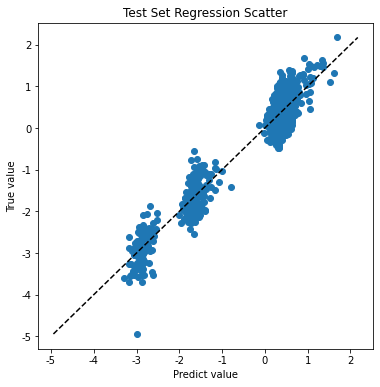

In [105]:
features_2 = ['非工资收入平均值','非工资收入次数月均值','工资占收入比例月均值','支出次数月均值']
features = features_1 + features_2
VarRegression(df, '分数', features)

分类任务：标签
变量：['职业', '教育程度', '信用卡数量', '工资收入平均值', '欠款金额平均值', '非工资收入平均值', '非工资收入次数月均值', '工资占收入比例月均值', '支出次数月均值']



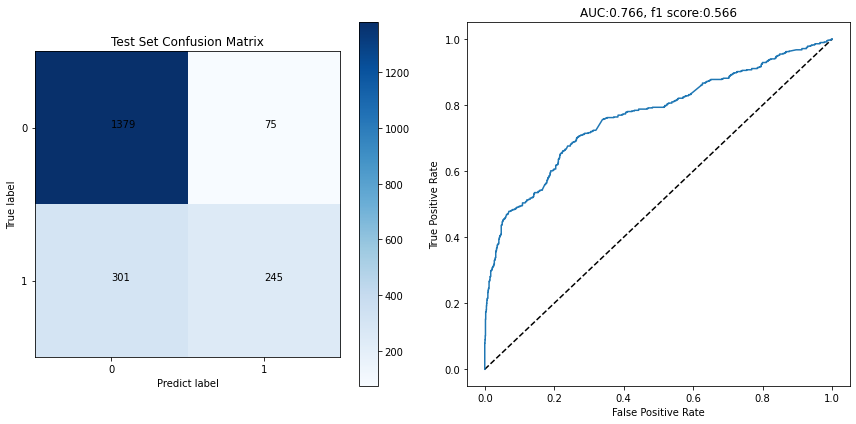

In [106]:
VarClassification(df, '标签', features)

# 特征工程 3
上期欠款占上期账单金额平均值、本期应还金额平均值、信用卡使用金额月均值、信用卡使用次数月均值、  
工资收入最大值、工资收入最小值、非工资收入最大值、非工资收入最小值。

In [107]:
# 上期欠款占上期账单金额平均值	（上期账单金额-上期还款金额）/上期账单金额
last_debt_ratio_mean = df_dict['账单'][['new_user_id','账单年月', '上期还款金额', '上期账单金额']].copy()
last_debt_ratio_mean.loc[:, '上期欠款比例'] = 1-x['上期还款金额']/x['上期账单金额']

last_debt_ratio_mean = last_debt_ratio_mean[(df_dict['银行流水']['交易年月'] != '-1')].groupby(['new_user_id'])['上期欠款比例'].agg(['mean'])
last_debt_ratio_mean.columns = ['上期欠款占上期账单金额平均值']
last_debt_ratio_mean.reset_index(inplace=True)
last_debt_ratio_mean.head()


,new_user_id,上期欠款占上期账单金额平均值
0,0000a11bede26d01990cd7bf86a4ffed,0.030869
1,0001102f53f24a8952ed5b47f9564354,-0.063940
2,000228d848615f1320914e0cf6064d12,-0.920420
3,0003f283dfacd7100bba76d876cf94da,-0.125129
4,000fc975cf7a868719446414a5034eae,0.013292


In [120]:
# 本期应还金额平均值	上期账单金额-上期还款金额+本期账单金额-调整金额+循环利息
ondue_mean = df_dict['账单'][['new_user_id','账单年月', '上期账单金额', '上期还款金额', '本期账单金额', '调整金额', '循环利息']].copy()
ondue_mean.loc[:,'本期应还金额'] = ondue_mean['上期账单金额'] - ondue_mean['上期还款金额'] + ondue_mean['本期账单金额'] - ondue_mean['调整金额'] + ondue_mean['循环利息']

ondue_mean = ondue_mean[(df_dict['银行流水']['交易年月'] != '-1')].groupby(['new_user_id'])['本期应还金额'].agg(['mean'])
ondue_mean.columns = ['本期应还金额平均值']
ondue_mean.reset_index(inplace=True)
ondue_mean.head()

C:\Users\bryan\AppData\Local\Temp/ipykernel_10496/1288901626.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ondue_mean = ondue_mean[(df_dict['银行流水']['交易年月'] != '-1')].groupby(['new_user_id'])['本期应还金额'].agg(['mean'])


,new_user_id,本期应还金额平均值
0,0000a11bede26d01990cd7bf86a4ffed,58.992290
1,0001102f53f24a8952ed5b47f9564354,26.549467
2,000228d848615f1320914e0cf6064d12,46.899987
3,0003f283dfacd7100bba76d876cf94da,42.336529
4,000fc975cf7a868719446414a5034eae,51.901119


In [109]:
# 信用卡使用金额月均值	sum_day_消费次数*本期账单金额
card_usage_mean = df_dict['账单'][['new_user_id','账单年月', '消费笔数','本期账单金额']].copy()
card_usage_mean.loc[:, '月使用量'] = card_usage_mean['消费笔数'] * card_usage_mean['本期账单金额']

card_usage_mean = card_usage_mean[(df_dict['银行流水']['交易年月'] != '-1')].groupby(['new_user_id', '账单年月'])['月使用量'].agg(['mean'])
card_usage_mean = card_usage_mean.groupby(['new_user_id']).agg(['mean'])
card_usage_mean.columns = ['信用卡使用金额月均值']
card_usage_mean.reset_index(inplace=True)
card_usage_mean.head()

,new_user_id,信用卡使用金额月均值
0,0000a11bede26d01990cd7bf86a4ffed,0.881917
1,0001102f53f24a8952ed5b47f9564354,8.477729
2,000228d848615f1320914e0cf6064d12,0.000000
3,0003f283dfacd7100bba76d876cf94da,24.897145
4,000fc975cf7a868719446414a5034eae,21.899043


In [110]:
# 信用卡使用次数月均值	sum_day_消费次数
card_frequence_mean = df_dict['账单'][['new_user_id','账单年月', '消费笔数']].copy()
card_frequence_mean = card_frequence_mean.groupby(['new_user_id','账单年月'])['消费笔数'].agg(['sum'])

card_frequence_mean = card_frequence_mean[(df_dict['银行流水']['交易年月'] != '-1')].groupby(['new_user_id']).agg(['mean'])
card_frequence_mean.columns = ['信用卡使用次数月均值']
card_frequence_mean.reset_index(inplace=True)
card_frequence_mean.head()

,new_user_id,信用卡使用次数月均值
0,0000a11bede26d01990cd7bf86a4ffed,0.066667
1,0001102f53f24a8952ed5b47f9564354,0.428571
2,000228d848615f1320914e0cf6064d12,0.000000
3,0003f283dfacd7100bba76d876cf94da,0.500000
4,000fc975cf7a868719446414a5034eae,16.000000


In [111]:
# 工资收入最大值	银行流水“交易类型”为0且“工资收入标记”为1的“交易金额”最大值
# 工资收入最小值	银行流水“交易类型”为0且“工资收入标记”为1的“交易金额”最小值
salary_max_min = df_dict['银行流水'][
    (df_dict['银行流水']['交易类型'] == 0) & 
    (df_dict['银行流水']['工资收入标记'] == 1) &
    (df_dict['银行流水']['交易年月'] != '-1')].groupby(['new_user_id'])['交易金额'].agg(['max','min'])
salary_max_min.columns = ['工资收入最大值','工资收入最小值']
salary_max_min.reset_index(inplace=True)
salary_max_min.head()

,new_user_id,工资收入最大值,工资收入最小值
0,00375b8a7a62da4f578f4f4464fc4228,46.691124,42.143743
1,00872649357929f1f3d7fafbe484810b,46.586552,46.172646
2,00e44c200eeb161df7d08ac1b79bd4a7,47.292812,47.292812
3,02419b54629f540d3430e6ba8230aac4,49.437313,41.042287
4,024c12c231362aa4206c001674abe30f,46.092562,37.215544


In [112]:
# 非工资收入最大值	银行流水“交易类型”为0且“工资收入标记”为0的“交易金额”最大值
# 非工资收入最小值	银行流水“交易类型”为0且“工资收入标记”为0的“交易金额”最小值
nonsalary_max_min = df_dict['银行流水'][
    (df_dict['银行流水']['交易类型'] == 0) & 
    (df_dict['银行流水']['工资收入标记'] == 0) & 
    (df_dict['银行流水']['交易年月'] != '-1')].groupby(['new_user_id'])['交易金额'].agg(['max','min'])
nonsalary_max_min.columns = ['非工资收入最大值','非工资收入最小值']
nonsalary_max_min.reset_index(inplace=True)
nonsalary_max_min.head()

,new_user_id,非工资收入最大值,非工资收入最小值
0,0003f283dfacd7100bba76d876cf94da,48.266228,35.308421
1,00284cf15ae27d1ddf4f93922cd7bcb5,49.442433,33.995400
2,00375b8a7a62da4f578f4f4464fc4228,50.060691,30.568844
3,0057bbe021e9c3fc79834e3ff126bb98,48.020046,36.128595
4,00872649357929f1f3d7fafbe484810b,47.502580,30.568844


In [113]:
df = pd.merge(df, last_debt_ratio_mean, on='new_user_id', how='left')
df = pd.merge(df, ondue_mean, on='new_user_id', how='left')
df = pd.merge(df, card_usage_mean, on='new_user_id', how='left')
df = pd.merge(df, card_frequence_mean, on='new_user_id', how='left')
df = pd.merge(df, salary_max_min, on='new_user_id', how='left')
df = pd.merge(df, nonsalary_max_min, on='new_user_id', how='left')
df = df.fillna(0)

# 回归与分类

回归任务：分数
变量：['职业', '教育程度', '信用卡数量', '工资收入平均值', '欠款金额平均值', '非工资收入平均值', '非工资收入次数月均值', '工资占收入比例月均值', '支出次数月均值', '上期欠款占上期账单金额平均值', '本期应还金额平均值', '信用卡使用金额月均值', '信用卡使用次数月均值', '工资收入最大值', '工资收入最小值', '非工资收入最大值', '非工资收入最小值']
均方差：0.0727



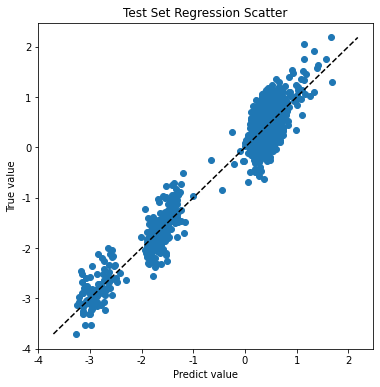

In [114]:
features_3 = ['上期欠款占上期账单金额平均值','本期应还金额平均值','信用卡使用金额月均值','信用卡使用次数月均值','工资收入最大值','工资收入最小值','非工资收入最大值','非工资收入最小值']
features = features_1 + features_2 + features_3
VarRegression(df, '分数', features)

C:\Users\bryan\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


分类任务：标签
变量：['职业', '教育程度', '信用卡数量', '工资收入平均值', '欠款金额平均值', '非工资收入平均值', '非工资收入次数月均值', '工资占收入比例月均值', '支出次数月均值', '上期欠款占上期账单金额平均值', '本期应还金额平均值', '信用卡使用金额月均值', '信用卡使用次数月均值', '工资收入最大值', '工资收入最小值', '非工资收入最大值', '非工资收入最小值']



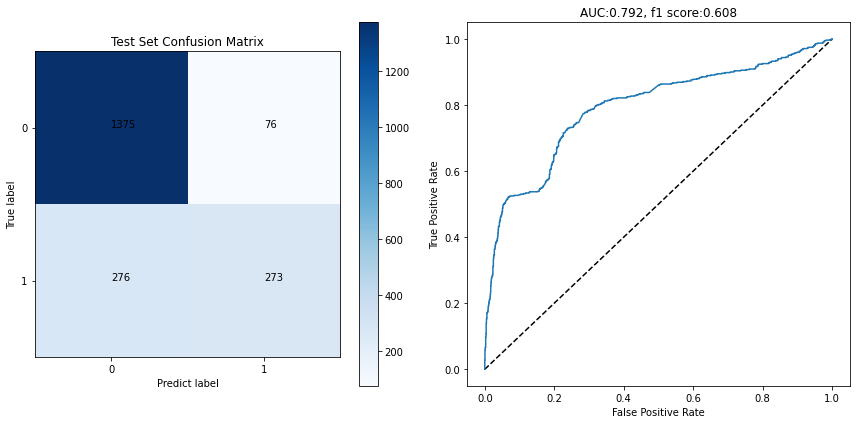

In [115]:
VarClassification(df, '标签', features)

# 特征工程 4
半年内工资收入、近季度工资收入、上季度工资收入、季度工资收入变化、  
半年内非工资收入、近季度非工资收入、上季度非工资收入、季度工资收入变化、  
每月消费-收入项方差、每季度消费-收入项方差、  
最低还款额最大值、最低还款额最小值、最低还款额平均值、  
信用卡额度最大值、信用卡额度最小值、信用卡额度平均值、  
预借现金额度最大值、预借现金额度最小值、预借现金额度平均值。

In [116]:
# 半年内工资收入	累加近180天内银行流水“交易类型”为0且“工资收入标记”为1的“交易金额”
# 近季度工资收入	累加近90天内银行流水“交易类型”为0且“工资收入标记”为1的“交易金额”
# 上季度工资收入	累加 90天前的 近90天内 银行流水“交易类型”为0且“工资收入标记”为1的“交易金额”
# 季度工资变化趋势	近季度大于上季度取1，否则取0

# 半年内非工资收入	累加近180天内银行流水“交易类型”为0且“工资收入标记”为0的“交易金额”
# 近季度非工资收入	累加近90天内银行流水“交易类型”为0且“工资收入标记”为0的“交易金额”
# 上季度非工资收入	累加 90天前的 近90天内 银行流水“交易类型”为0且“工资收入标记”为01的“交易金额”
# 季度非工资收入变化	近季度大于上季度取1，否则取0

# 每月盈余方差	每月交易类型为0-交易类型为1的方差
# 每季度盈余方差	每季度交易类型为0-交易类型为1的方差

In [117]:
def cust_period(value, op="days", op_period=0, base_dt=None):
    value_list = value.tolist()
    
    while "-1" in value_list:
        value_list.remove("-1")
    if len(value_list) != 0:
        if not base_dt:
            max_dt = max(value_list)
        else:
            max_dt = base_dt

        if op == "years":
            end_dt = (datetime.datetime.strptime(max_dt, "%Y-%m-%d %H:%M:%S") + relativedelta(years=-op_period)).strftime("%Y-%m-%d %H:%M:%S")
        elif op == "months":
            end_dt = (datetime.datetime.strptime(max_dt, "%Y-%m-%d %H:%M:%S") + relativedelta(months=-op_period)).strftime("%Y-%m-%d %H:%M:%S")
        elif op == "weeks":
            end_dt = (datetime.datetime.strptime(max_dt, "%Y-%m-%d %H:%M:%S") + relativedelta(weeks=-op_period)).strftime("%Y-%m-%d %H:%M:%S")
        elif op == "days":
            end_dt = (datetime.datetime.strptime(max_dt, "%Y-%m-%d %H:%M:%S") + relativedelta(days=-op_period)).strftime("%Y-%m-%d %H:%M:%S")
        else:
            print("Wrong operation unit of time!")
            exit()
        period = list(value.values >= end_dt)
        return period
    else:
        return [True]*len(value.tolist())

In [123]:
# 最低还款额最大值	
# 最低还款额最小值	
# 最低还款额平均值	
mini_repayment = df_dict['账单'][(df_dict['账单']['账单年月'] != '-1')].groupby(['new_user_id'])['本期账单最低还款额'].agg(['max','min','mean'])
mini_repayment.columns = ['最低还款额最大值','最低还款额最小值','最低还款额平均值']
mini_repayment.reset_index(inplace=True)
display(mini_repayment.head())

# 信用卡额度最大值	
# 信用卡额度最小值	
# 信用卡额度平均值	
card_limit = df_dict['账单'][(df_dict['账单']['账单年月'] != '-1')].groupby(['new_user_id'])['信用卡额度'].agg(['max','min','mean'])
card_limit.columns = ['信用卡额度最大值','信用卡额度最小值','信用卡额度平均值']
card_limit.reset_index(inplace=True)
display(card_limit.head())

# 预借现金额度最大值	
# 预借现金额度最小值	
# 预借现金额度平均值	
cash_advlimit = df_dict['账单'][(df_dict['账单']['账单年月'] != '-1')].groupby(['new_user_id'])['预借现金额度'].agg(['max','min','mean'])
cash_advlimit.columns = ['预借现金额度最大值','预借现金额度最小值','预借现金额度平均值']
cash_advlimit.reset_index(inplace=True)
display(cash_advlimit.head())

,new_user_id,最低还款额最大值,最低还款额最小值,最低还款额平均值
0,0000a11bede26d01990cd7bf86a4ffed,49.936778,48.386835,49.195663
1,0001102f53f24a8952ed5b47f9564354,51.319587,26.457513,41.852041
2,000228d848615f1320914e0cf6064d12,48.993768,48.993768,48.993768
3,0003f283dfacd7100bba76d876cf94da,48.020046,26.457513,43.397446
4,0016685918eebd93925824b60710a1f0,52.129570,26.457513,48.557546


,new_user_id,信用卡额度最大值,信用卡额度最小值,信用卡额度平均值
0,0000a11bede26d01990cd7bf86a4ffed,51.933872,51.439717,51.686795
1,0001102f53f24a8952ed5b47f9564354,52.496721,49.667581,51.857833
2,000228d848615f1320914e0cf6064d12,51.439717,51.439717,51.439717
3,0003f283dfacd7100bba76d876cf94da,50.360533,26.457513,45.579929
4,0016685918eebd93925824b60710a1f0,53.460928,26.457513,50.447889


,new_user_id,预借现金额度最大值,预借现金额度最小值,预借现金额度平均值
0,0000a11bede26d01990cd7bf86a4ffed,51.262192,50.761499,51.011845
1,0001102f53f24a8952ed5b47f9564354,51.832335,26.457513,49.684566
2,000228d848615f1320914e0cf6064d12,50.761499,50.761499,50.761499
3,0003f283dfacd7100bba76d876cf94da,26.457513,26.457513,26.457513
4,0016685918eebd93925824b60710a1f0,52.808674,26.457513,47.681649
